## Import necessary libraries

In [2]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import cv2
import os
import shutil

# Define global variables

In [4]:
IMG_SIZE = 512
PATCH_SIZE = 16
BATCH_SIZE = 32
NUM_EPOCHS = 10

# Create the datasets

In [40]:
train_animal_imgs = len(os.listdir('/content/drive/MyDrive/Datasets/CV/Instagram_images/Train/wild_animals'))
test_animal_imgs = len(os.listdir('/content/drive/MyDrive/Datasets/CV/Instagram_images/Test/wild_animals'))
train_landscape_imgs = len(os.listdir('/content/drive/MyDrive/Datasets/CV/Instagram_images/Train/landscapes'))
test_landscape_imgs = len(os.listdir('/content/drive/MyDrive/Datasets/CV/Instagram_images/Test/landscapes'))
train_animal_imgs, test_animal_imgs, train_landscape_imgs, test_landscape_imgs

(4060, 800, 3519, 800)

## Create the image dataset

In [41]:
# Create train, test, and validation image datasets
train_data, validation_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Datasets/CV/Instagram_images/Train',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both',
    interpolation='bilinear'
)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Datasets/CV/Instagram_images/Test',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    interpolation='bilinear'
)

Found 7579 files belonging to 2 classes.
Using 6064 files for training.
Using 1515 files for validation.
Found 1600 files belonging to 2 classes.


In [42]:
train_dataset = train_data.prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_data.prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.prefetch(tf.data.AUTOTUNE)

## Create the artificial dataset for animals and landscapes *(assuming landscape images are more popular)*

In [43]:
# Generate random data samples for train and test datasets
animal_comm = np.random.randint(low=1, high=1000, size=train_animal_imgs+test_animal_imgs)
animal_dist = np.random.randint(low=1, high=10000, size=train_animal_imgs+test_animal_imgs)
animal_like = np.random.randint(low=1, high=100000, size=train_animal_imgs+test_animal_imgs)

landscape_comm = np.random.randint(low=1, high=10000, size=train_landscape_imgs+test_landscape_imgs)
landscape_dist = np.random.randint(low=1, high=100000, size=train_landscape_imgs+test_landscape_imgs)
landscape_like = np.random.randint(low=1, high=1000000, size=train_landscape_imgs+test_landscape_imgs)

In [44]:
train_comm_concat = np.concatenate((landscape_comm[:train_landscape_imgs], animal_comm[:train_animal_imgs]), axis=None)
train_dist_concat = np.concatenate((landscape_dist[:train_landscape_imgs], animal_dist[:train_animal_imgs]), axis=None)
train_like_concat = np.concatenate((landscape_like[:train_landscape_imgs], animal_like[:train_animal_imgs]), axis=None)

test_comm_concat = np.concatenate((landscape_comm[train_landscape_imgs:], animal_comm[train_animal_imgs:]), axis=None)
test_dist_concat = np.concatenate((landscape_dist[train_landscape_imgs:], animal_dist[train_animal_imgs:]), axis=None)
test_like_concat = np.concatenate((landscape_like[train_landscape_imgs:], animal_like[train_animal_imgs:]), axis=None)

In [45]:
train_artificial_data = zip(train_comm_concat, train_dist_concat, train_like_concat)
test_artificial_data = zip(test_comm_concat, test_dist_concat, test_like_concat)

In [46]:
# Define column names for DataFrames
columns = ['comments', 'distributions', 'likes']

train_df = pd.DataFrame(data=train_artificial_data,
                               columns=columns)
test_df = pd.DataFrame(data=test_artificial_data,
                               columns=columns)

In [47]:
train_df

,comments,distributions,likes
0,8684,84888,544238
1,2891,3781,553140
2,133,6366,419744
3,796,55404,197006
4,8938,16848,780517
...,...,...,...
7574,348,149,39731
7575,929,5475,9655
7576,215,8235,38044
7577,894,3042,8631


In [48]:
test_df

,comments,distributions,likes
0,1983,75846,435970
1,9073,23310,670473
2,9480,93650,77943
3,8533,61935,272043
4,7093,57609,376754
...,...,...,...
1595,2,4429,67398
1596,106,6442,67838
1597,108,4619,18963
1598,493,8850,74081


In [49]:
transformed_train_data = MinMaxScaler().fit_transform(train_df[['comments', 'distributions']].to_numpy())
train_df['comments'] = transformed_train_data[:, 0]
train_df['distributions'] = transformed_train_data[:, 1]

In [50]:
transformed_test_data = MinMaxScaler().fit_transform(test_df[['comments', 'distributions']].to_numpy())
test_df['comments'] = transformed_test_data[:, 0]
test_df['distributions'] = transformed_test_data[:, 1]

In [51]:
train_df

,comments,distributions,likes
0,0.868474,0.849337,544238
1,0.289058,0.037821,553140
2,0.013203,0.063685,419744
3,0.079516,0.554335,197006
4,0.893879,0.168563,780517
...,...,...,...
7574,0.034707,0.001481,39731
7575,0.092819,0.054770,9655
7576,0.021404,0.082385,38044
7577,0.089318,0.030427,8631


In [52]:
test_df

,comments,distributions,likes
0,0.198339,0.758468,435970
1,0.907835,0.233082,670473
2,0.948564,0.936517,77943
3,0.853798,0.619351,272043
4,0.709697,0.576089,376754
...,...,...,...
1595,0.000100,0.044262,67398
1596,0.010507,0.064393,67838
1597,0.010707,0.046162,18963
1598,0.049234,0.088474,74081


In [53]:
# Set seeds for reproducibility
tf.random.set_seed(42)

# Shuffle with seed
shuffled_train_data = tf.cast(tf.random.shuffle(train_df, seed=42), dtype=tf.float32)

In [54]:
# Define percentage split
percentage_split = 0.8

# Split the training data into train and validation
shuffled_train_att = shuffled_train_data[:round(len(shuffled_train_data)*percentage_split)+1]
shuffled_validation_att = shuffled_train_data[round(len(shuffled_train_data)*percentage_split)+1:]

train_artificial_features = tf.data.Dataset.from_tensor_slices(shuffled_train_att[:, :2])
train_artificial_labels = tf.data.Dataset.from_tensor_slices(shuffled_train_att[:, 2])
train_artificial_data = tf.data.Dataset.zip((train_artificial_features, train_artificial_labels))

validation_artificial_features = tf.data.Dataset.from_tensor_slices(shuffled_validation_att[:, :2])
validation_artificial_labels = tf.data.Dataset.from_tensor_slices(shuffled_validation_att[:, 2])
validation_artificial_data = tf.data.Dataset.zip((validation_artificial_features, validation_artificial_labels))

test_artificial_features = tf.data.Dataset.from_tensor_slices(test_df[['comments', 'distributions']])
test_artificial_labels = tf.data.Dataset.from_tensor_slices(test_df['likes'])
test_artificial_data = tf.data.Dataset.zip(test_artificial_features, test_artificial_labels)

train_artificial_data.cardinality().numpy(), validation_artificial_data.cardinality().numpy(), test_artificial_data.cardinality().numpy()

(6064, 1515, 1600)

In [55]:
# last_element = tf.data.Dataset.from_tensor_slices(np.expand_dims(list(validation_artificial_data.as_numpy_iterator())[-1], axis=0))

In [56]:
# train_artificial_data = train_artificial_data.concatenate(last_element)
# validation_artificial_data = validation_artificial_data.take(len(validation_artificial_data)-1)
# train_artificial_data.cardinality().numpy(), validation_artificial_data.cardinality().numpy()

In [57]:
train_artificial_data = train_artificial_data.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_artificial_data = validation_artificial_data.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_artificial_data = test_artificial_data.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [58]:
zipped_train_dataset = tf.data.Dataset.zip((train_data, train_artificial_data))
zipped_train_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), (TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None)))>

In [59]:
zipped_validation_dataset = tf.data.Dataset.zip((validation_data, validation_artificial_data))
zipped_validation_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), (TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None)))>

In [60]:
zipped_test_dataset = tf.data.Dataset.zip((test_data, test_artificial_data))
zipped_test_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), (TensorSpec(shape=(None, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)))>

In [61]:
def reshape_dataset(data1, data2):
    # Unpack the data
    image, image_label = data1
    attributes, regression_label = data2

    # Define the inputs
    inputs = (image, attributes)

    # Define the outputs
    outputs = (image_label, regression_label)

    return inputs, outputs


In [62]:
# Apply the transformation for train dataset
prepared_train_dataset = zipped_train_dataset.map(reshape_dataset)
prepared_train_dataset

<_MapDataset element_spec=((TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)), (TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None)))>

In [63]:
# Apply the transformation for validation dataset
prepared_validation_dataset = zipped_validation_dataset.map(reshape_dataset)
prepared_validation_dataset

<_MapDataset element_spec=((TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)), (TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None)))>

In [64]:
# Apply the transformation for train dataset
prepared_test_dataset = zipped_test_dataset.map(reshape_dataset)
prepared_test_dataset

<_MapDataset element_spec=((TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None)), (TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)))>

# Define a Multi-layer perceptron

In [65]:
def mlp(x, hidden_units):
    # Iterate through the list of hidden units
    for units in hidden_units:
        # Apply a Dense layer with the GELU activation function
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)

        # # Apply a Dropout layer with a specified dropout rate
        # x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Return the final output after processing through the MLP
    return x

# Define class to extract image patches

In [66]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    # Override the get_config function to ensure model saving compatibility
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "patch_size": patch_size
            }
        )
        return config

    def call(self, images):
        # Get the batch size of the input images
        batch_size = tf.shape(images)[0]

        # Extract image patches using TensorFlow's 'extract_patches' function
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to have the shape [batch_size, num_patches, patch_size * patch_size * channels]
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

# Visualize image patches

Image size: 512 X 512
Patch size: 16 X 16
1024 patches per image 
768 elements per patch


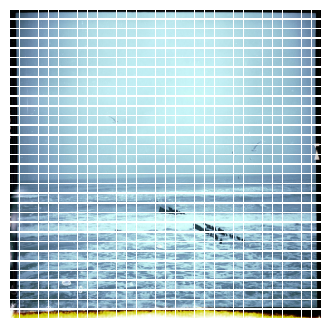

In [67]:
# Extract patches from the image using the 'Patches' layer
patches = Patches(PATCH_SIZE)(tf.convert_to_tensor([list(train_dataset.unbatch().take(1).as_numpy_iterator())[0][0].astype(np.uint8)]))

# Print information about the image and patch sizes
print(f"Image size: {IMG_SIZE} X {IMG_SIZE}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

# Calculate the number of patches to be displayed in each row and column
n = int(np.sqrt(patches.shape[1]))

# Create a new figure for displaying the extracted patches
plt.figure(figsize=(4, 4))

# Iterate through and display each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)  # Create a subplot
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))  # Reshape the patch to image dimensions
    plt.imshow(patch_img.numpy().astype("uint8"))  # Display the patch as an image
    plt.axis("off")  # Turn off axis labels and ticks for the patch

# Define an encoder for image patches

In [68]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches

        # Initialize a Dense layer for projection
        self.projection = tf.keras.layers.Dense(units=projection_dim)

        # Initialize an Embedding layer for position embeddings
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches,
            output_dim=projection_dim
        )

    # Override the get_config function to ensure model saving compatibility
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "num_patches": num_patches,
                "projection_dim": projection_dim
            }
        )
        return config

    def call(self, patch):
        # Create positions for the patches
        positions = tf.range(start=0, limit=self.num_patches, delta=1)

        # Perform projection and add position embeddings to the patches
        encoded = self.projection(patch) + self.position_embedding(positions)

        # Return the encoded patches
        return encoded

# Define ViT architecture

In [69]:
def create_vit(input_img_shape,
               input_num_shape,
               patch_size,
               num_patches,
               projection_dim,
               num_heads,
               transformer_units,
               transformer_layers,
               mlp_head_units):

    # Define the input layer for the images
    img_inputs = tf.keras.layers.Input(shape=input_img_shape, name='image_input')

    # Define the input layer for the numerical data
    num_inputs = tf.keras.layers.Input(shape=input_num_shape, name='numerical_input')

    # Create patches from input images
    patches = Patches(patch_size)(img_inputs)

    # Encode the patches using the PatchEncoder layer
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Apply multi-head self-attention to the patches
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)

        # Apply an MLP to the output
        x4 = mlp(x3, hidden_units=transformer_units)

        # Skip connection 2
        encoded_patches = tf.keras.layers.Add()([x4, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(rate=0.1)(representation)

    # Add an additional MLP for feature extraction (classification)
    classification_features = mlp(representation, hidden_units=mlp_head_units)

    # Output layer with 1 neuron representing the class of the image (classification)
    classification_outputs = tf.keras.layers.Dense(units=1,
                                                   activation='sigmoid',
                                                   name='classification_output')(classification_features)

    # Conv1D layer (regression)
    regression_features = tf.keras.layers.Conv1D(filters=128,
                                                 kernel_size=3,
                                                 strides=1,
                                                 padding='same',
                                                 activation='relu')(tf.expand_dims(num_inputs, axis=1))

    # Dense layer (regression)
    regression_features = tf.keras.layers.Dense(units=512,
                                                activation='linear')(regression_features)

    # BatchNormalization layer (regression)
    regression_features = tf.keras.layers.BatchNormalization(axis=-1)(regression_features)

    # Dropout layer (regression)
    regression_features = tf.keras.layers.Dropout(rate=0.1)(regression_features)

    # Concatenate layer (regression)
    regression_features = tf.keras.layers.Concatenate(axis=-1)([representation,
                                                                tf.squeeze(regression_features, axis=1)])

    # Output layer with 1 neuron representing the number of likes for an image (regression)
    regression_outputs = tf.keras.layers.Dense(units=1,
                                               activation='linear',
                                               name='regression_output')(regression_features)

    # Return the Keras model
    return tf.keras.models.Model(inputs=[img_inputs,
                                         num_inputs],
                                 outputs=[classification_outputs,
                                          regression_outputs],
                                 name='ViT_model')

## Training the ViT model

In [70]:
def run_experiment(model, learning_rate, num_epochs):
    # Define the optimizer
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate
    )

    # Compile the model using Mean Absolute Error as the loss
    model.compile(optimizer=optimizer,
                  loss={'classification_output': 'binary_crossentropy', 'regression_output': 'mae'},
                  metrics={'classification_output': ['accuracy'], 'regression_output': ['mae']})

    # Set up a ModelCheckpoint to save the best model weights
    # checkpoint_filepath = "logs/"
    # checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    #     checkpoint_filepath,
    #     monitor="val_loss",
    #     save_best_only=True,
    #     save_weights_only=True
    # )

    # Train the model
    model_history = model.fit(
        prepared_train_dataset,
        epochs=num_epochs,
        validation_data=prepared_validation_dataset,
        validation_steps=int(0.2*len(prepared_validation_dataset)),
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_classification_output_loss',
                                                 factor=0.1,
                                                 patience=3,
                                                 verbose=1),
            tf.keras.callbacks.EarlyStopping(monitor="val_classification_output_loss",
                                             min_delta=0.01,
                                             patience=5,
                                             verbose=1,
                                             restore_best_weights=False)
        ]
    )

    return model_history

In [71]:
# Define input image shape and input numerical shape
input_img_shape = (IMG_SIZE, IMG_SIZE, 3)
input_num_shape = (2,)
learning_rate = 0.0001

# Calculate the number of patches
num_patches = (IMG_SIZE // PATCH_SIZE) ** 2

# Define the dimensions and layers for the Vision Transformer (ViT) model
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 128, 64]

# Create a ViT-based model
vit_classification = create_vit(input_img_shape,
                                input_num_shape,
                                PATCH_SIZE,
                                num_patches,
                                projection_dim,
                                num_heads,
                                transformer_units,
                                transformer_layers,
                                mlp_head_units)

In [72]:
# Display ViT model summary
vit_classification.summary()

Model: "ViT_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 patches_3 (Patches)         (None, None, 768)            0         ['image_input[0][0]']         
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 1024, 64)             114752    ['patches_3[0][0]']           
 der)                                                                                             
                                                                                                  
 layer_normalization_13 (La  (None, 1024, 64)             128       ['patch_encoder_1[0][0

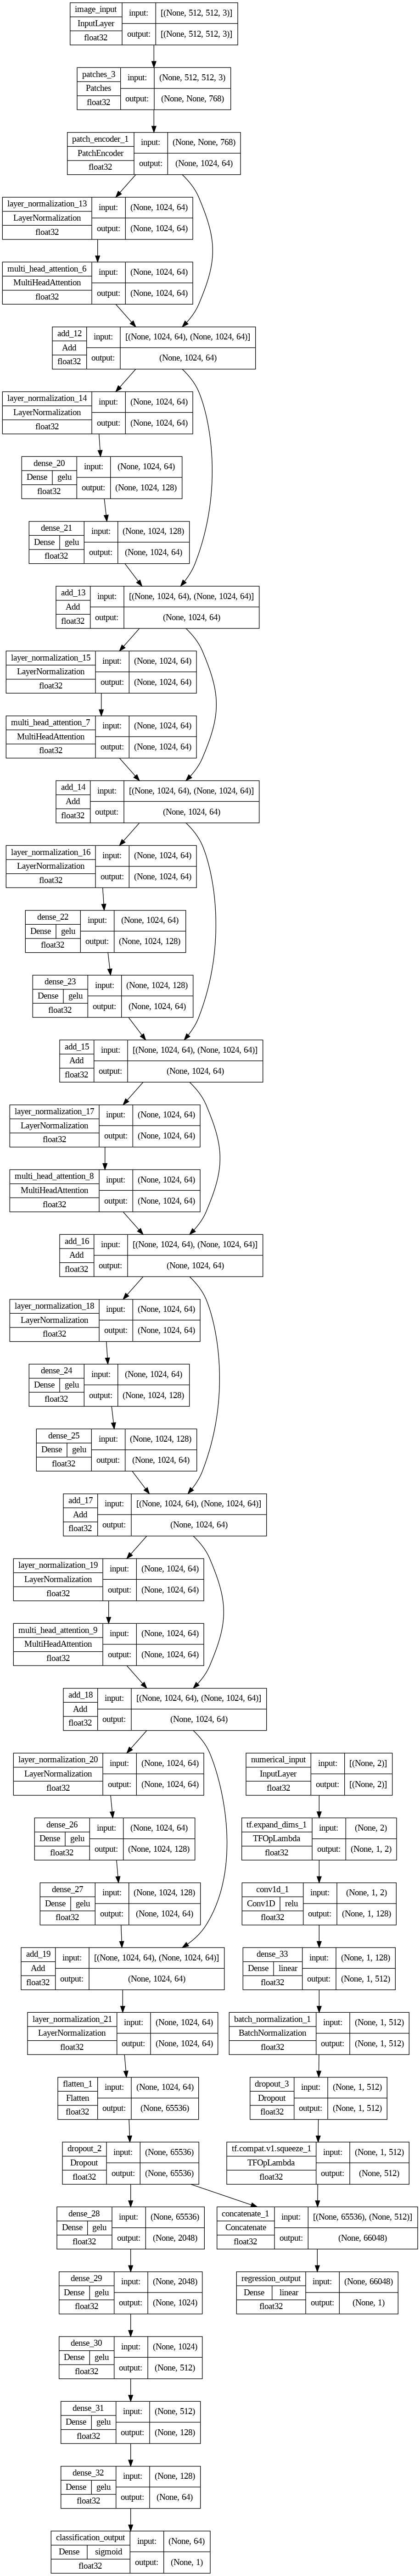

In [73]:
# Plot the architecture of the ViT model
tf.keras.utils.plot_model(model=vit_classification,
                          to_file='ViT_model.png',
                          show_shapes=True,
                          show_dtype=True,
                          show_layer_names=True,
                          show_layer_activations=True)

In [74]:
# Train the model and store the training history
model_history = run_experiment(vit_classification,
                               learning_rate,
                               NUM_EPOCHS)

Epoch 1/10
190/190 [==============================] - 119s 542ms/step - loss: 256970.9531 - classification_output_loss: 0.8187 - regression_output_loss: 256970.0625 - classification_output_accuracy: 0.5257 - regression_output_mae: 256970.0625 - val_loss: 269458.9062 - val_classification_output_loss: 0.6888 - val_regression_output_loss: 269458.2188 - val_classification_output_accuracy: 0.4757 - val_regression_output_mae: 269458.2188 - lr: 1.0000e-04
Epoch 2/10
190/190 [==============================] - 102s 530ms/step - loss: 255558.9219 - classification_output_loss: 0.7552 - regression_output_loss: 255558.4219 - classification_output_accuracy: 0.5181 - regression_output_mae: 255558.4219 - val_loss: 267984.9062 - val_classification_output_loss: 0.7372 - val_regression_output_loss: 267984.1562 - val_classification_output_accuracy: 0.5278 - val_regression_output_mae: 267984.1562 - lr: 1.0000e-04
Epoch 3/10
190/190 [==============================] - 101s 526ms/step - loss: 254012.7344 - cl

## Making predictions using the ViT model

In [75]:
# Evaluate on the full validation dataset
vit_classification.evaluate(prepared_validation_dataset)

48/48 [==============================] - 90s 2s/step - loss: 263334.0000 - classification_output_loss: 0.6894 - regression_output_loss: 263333.3125 - classification_output_accuracy: 0.4713 - regression_output_mae: 263333.3125


[263334.0, 0.6893630623817444, 263333.3125, 0.4712871313095093, 263333.3125]

In [76]:
vit_predictions = vit_classification.predict(prepared_test_dataset)
vit_predictions

50/50 [==============================] - 143s 3s/step


[array([[0.48092607],
        [0.4681562 ],
        [0.47782883],
        ...,
        [0.47834665],
        [0.4974044 ],
        [0.49175945]], dtype=float32),
 array([[1355.0941],
        [1356.3236],
        [1356.5101],
        ...,
        [1356.0746],
        [1355.25  ],
        [1356.3936]], dtype=float32)]

# Plot the ViT model metrics

In [77]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=True):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Parameters:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels. If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
        norm: normalize values or not (default=False).
        savefig: save confusion matrix to file (default=False).

    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
            xlabel="Predicted label",
            ylabel="True label",
            xticks=np.arange(n_classes), # create enough axis slots for each class
            yticks=np.arange(n_classes),
            xticklabels=labels, # axes will labeled with class names (if they exist) or ints
            yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [79]:
def plot_loss_accuracy_curves(model_history):
    """
    Returns separate loss curves for training and validation metrics.

    Parameters:
        history: TensorFlow model History object
    """

    # Get the loss curves
    loss = model_history.history["classification_output_loss"]
    val_loss = model_history.history["val_classification_output_loss"]

    # Get the accuracy curves
    acc = model_history.history["classification_output_accuracy"]
    val_acc = model_history.history["val_classification_output_accuracy"]

    # Set the number of epochs
    epochs = range(len(model_history.history["classification_output_loss"]))

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="training_accuracy")
    plt.plot(epochs, val_acc, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()


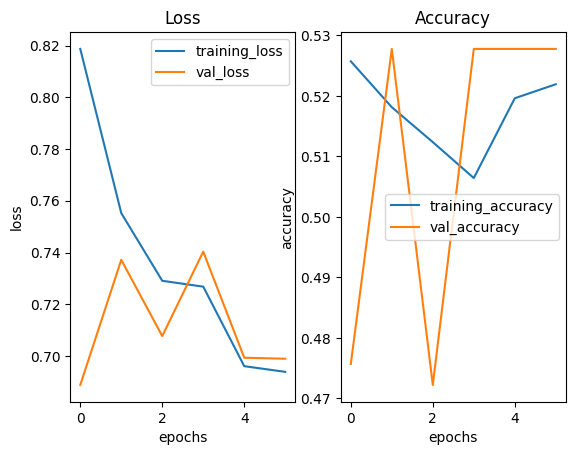

In [80]:
plot_loss_accuracy_curves(model_history)

In [87]:
ground_truth = []
for _, label in list(test_data.unbatch().as_numpy_iterator()):
    ground_truth.append(label[0])

In [85]:
predicted_labels = np.round(vit_predictions[0])

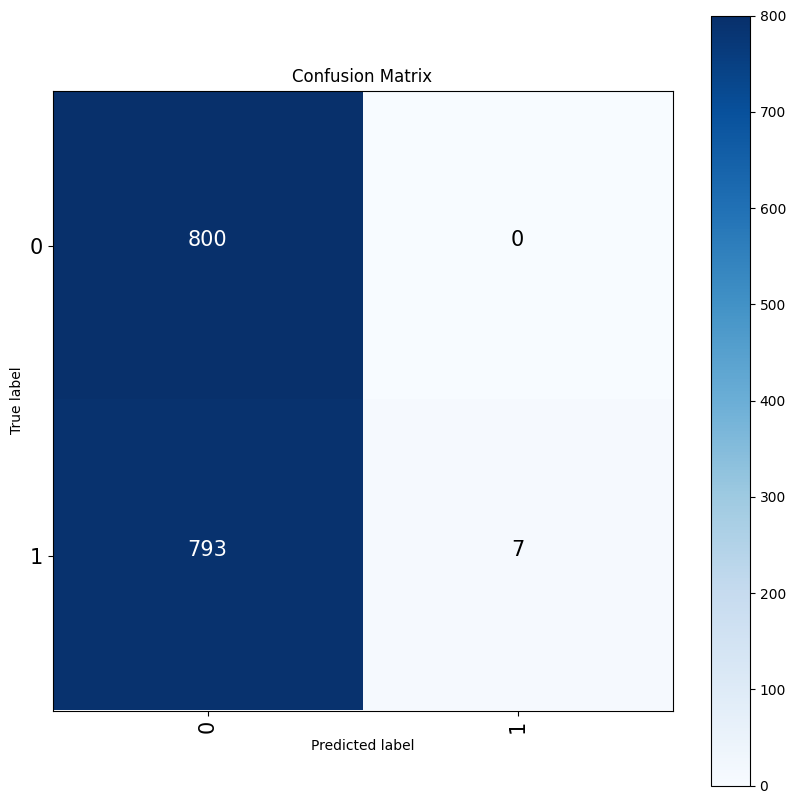

In [92]:
make_confusion_matrix(np.array(ground_truth), np.squeeze(predicted_labels, axis=-1))

In [94]:
dict_report = classification_report(np.array(ground_truth),
                                    np.squeeze(predicted_labels, axis=-1),
                                    output_dict=True)
report_df = pd.DataFrame(dict_report).transpose()
report_df

,precision,recall,f1-score,support
0.0,0.502197,1.000000,0.668617,800.000000
1.0,1.000000,0.008750,0.017348,800.000000
accuracy,0.504375,0.504375,0.504375,0.504375
macro avg,0.751099,0.504375,0.342983,1600.000000
weighted avg,0.751099,0.504375,0.342983,1600.000000


## Testing ViT model on unseen data

In [5]:
# Read the image file
image_string = tf.io.read_file('/content/Gura_Portitei_Scara_010.jpg')

# Decode the image file to a tensor
image = tf.image.decode_jpeg(image_string, channels=3)

# Resize the image to the desired shape
desired_shape = [IMG_SIZE, IMG_SIZE]  # Specify your desired height and width
resized_image = tf.image.resize(image, desired_shape)

In [108]:
predictions = vit_classification.predict([tf.expand_dims(resized_image, axis=0), tf.expand_dims(tf.constant([100, 1000]), axis=0)])

1/1 [==============================] - 1s 870ms/step


[array([[0.4778713]], dtype=float32), array([[1457.4584]], dtype=float32)]

In [8]:
text_upper_left_class = str(train_data.class_names[round(predictions[0][0][0])])
text_upper_right_likes = str(round(predictions[1][0][0]))

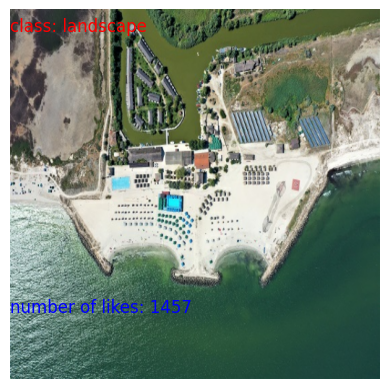

In [14]:
# Create a figure and axis to show the image
fig, ax = plt.subplots()

# Display the image
ax.imshow(tf.cast(resized_image, dtype=tf.uint8))

# Set text on the upper left corner
ax.text(0, 10, "class: " + text_upper_left_class, color="red", fontsize=12, ha='left', va='top')

# Set text on the upper right corner
ax.text(0, 400, "number of likes: " + text_upper_right_likes, color="blue", fontsize=12, ha='left', va='top')

# Hide the axis
ax.axis('off')

# Show the image
plt.show()